In [1]:
import json
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [2]:
def load_json(json_file_path, columns=["leftPD", "rightPD"], need_index=False) -> list[dict]:
    # 读取JSON文件
    try:
        with open(json_file_path, 'r') as f:
            data = json.load(f)
    except:
        with open(json_file_path, 'r', encoding='utf-8-sig') as f:
            data = json.load(f)
    
    # 提取records列表
    records = data.get('records', [])
    
    # 准备数据列表
    rows = []
    for idx, record in enumerate(records):
        if need_index:
            _temp = {"index": idx}
        else:
            _temp = { }
        _temp.update({ _k : record.get(_k, np.nan) for _k in columns })
        # 添加行数据
        rows.append(_temp)
    
    return rows

In [3]:
def get_continuous_values(numbers):
    if not numbers:
        return []
    
    ranges = []
    start = numbers[0]
    end = numbers[0]
    
    for i in range(1, len(numbers)):
        if numbers[i] == end + 1:
            # 连续，扩展当前范围
            end = numbers[i]
        else:
            # 不连续，保存当前范围并开始新的
            ranges.append((start, end))
            start = numbers[i]
            end = numbers[i]

    ranges.append((start, end))
    return ranges

def split_raw_data(raw_data) -> list:
     # 找到所有videoName的位置
    video_indices = []
    for i, item in enumerate(raw_data):
        if item['videoName'] != '':
            video_indices.append(i)

    if not video_indices:
        # 如果没有视频，整个列表都是RGB变化
        return {'light_changes': raw_data}
    
    _v_start_end_pairs = get_continuous_values(video_indices)

    v_segs = {}
    last_end = 0
    for _, pair in enumerate(_v_start_end_pairs):
        _temp = raw_data[last_end : pair[1]+1]
        v_segs[raw_data[pair[1]]["videoName"]] = _temp
        last_end = pair[1]+1
    v_segs.update({'light_changes': raw_data[last_end:]})
    return v_segs

In [4]:
# raw_data = load_json(
#         "E:\LightYourEyesData\实验一\方数鸿21-1\单色1_20250822_172444.json", 
#         columns=["leftPD", "rightPD", "videoName", "skyboxColorRGB"]
#     )
# type_sep_data = split_raw_data(raw_data)

In [5]:
import os
def load_data_from_disk(root_dir, data_type="light_changes" ,test_type="单色1", test_times=1):
    res = {}

    for _p in os.listdir(root_dir):
        people_path = os.path.join(root_dir, _p)

        if os.path.isdir(people_path) and _p.endswith(f"-{test_times}"):

            for _f in os.listdir(people_path):
                if os.path.basename(_f).startswith(test_type):
                    _p_raw_data = load_json(
                        os.path.join(people_path, _f), 
                        columns=["leftPD", "rightPD", "videoName", "skyboxColorRGB"]
                    )
                    _split_raw_data = split_raw_data(_p_raw_data)

                    res[_p.split("-")[0]] = _split_raw_data[data_type]
    return res

In [6]:
from Preprocessing import deBlink, fill_nan, transPercent, lowPass, window_smooth


def process_to_df(raw_data, sample_rate=50, max_blink_dura=10, smooth_win=0):
    _res = {}
    for _p in raw_data:
        _p_df = pd.DataFrame(raw_data[_p])

        _temp_l = _p_df["leftPD"].values
        _temp_l = deBlink(
            _temp_l,
            max_blink_dura=max_blink_dura,
        )
        _temp_l = fill_nan(_temp_l, method="both")
        _temp_l = lowPass(
            _temp_l,
            cutoff=15,
            fs=sample_rate,
        )
        _temp_l = transPercent(
            _temp_l,
            method="max"
        )
        if smooth_win>0:
            _temp_l = window_smooth(_temp_l, smooth_win)
        _p_df["leftPD"] = _temp_l
        
        _temp_r = _p_df["rightPD"].values
        _temp_r = deBlink(
            _temp_r,
            max_blink_dura=max_blink_dura,
        )
        _temp_r = fill_nan(_temp_r, method="both")
        _temp_r = lowPass(
            _temp_r,
            cutoff=15,
            fs=sample_rate,
        )
        _temp_r = transPercent(
            _temp_r,
            method="max"
        )
        if smooth_win>0:
            _temp_r = window_smooth(_temp_r, smooth_win)
        _p_df["rightPD"] = _temp_r

        _res[_p] = _p_df
    return _res

In [7]:
onesec_light_data = load_data_from_disk(
    "E:\LightYourEyesData\实验一",
    data_type="light_changes",
    # test_type="单色1",
    test_type="单色1",
    test_times=1
)

onesec_light_df = process_to_df(
    onesec_light_data,
    smooth_win=20
)

In [8]:
def segment_frame_data_by_index(data, start_time: float = 1.0,
                               duration: float = 3.0, step: float = 2.0,
                               sampling_rate: float = 50.0):
    if data is None:
        return []
    
    total_frames = data.shape[0]
    
    # 计算帧索引相关的参数
    start_frame = int(start_time * sampling_rate)
    while 1:
        if data.iloc[start_frame]["skyboxColorRGB"] == data.iloc[start_frame+1]["skyboxColorRGB"]:
            break
        start_frame+=1
    frames_per_segment = int(duration * sampling_rate)
    frames_per_step = int(step * sampling_rate)
    
    segments = []
    current_start_frame = start_frame
    
    while current_start_frame + frames_per_segment <= total_frames:
        end_frame = current_start_frame + frames_per_segment
        # 获取分段数据
        segment_data = data.iloc[current_start_frame:end_frame].copy()
        segments.append(segment_data)
        current_start_frame += frames_per_step
        while 1:
            if data.iloc[current_start_frame]["skyboxColorRGB"] == data.iloc[current_start_frame+1]["skyboxColorRGB"]:
                break
            current_start_frame+=1
    
    return segments

In [9]:
from Light import rgb_to_energy_spectral

def cut_light_change(raw_data,
                start_time=1,
                duration=3,
                step=2,
                sampling_rate=50):
    _res = []
    for _p in raw_data.keys():
        segs = segment_frame_data_by_index(
                raw_data[_p],
                start_time=start_time,
                duration=duration,
                step=step,
                sampling_rate=sampling_rate
            )
        for _s in segs:
            _s_rgb = _s.iloc[0]["skyboxColorRGB"]
            _e_rgb = _s.iloc[-1]["skyboxColorRGB"]
            _s_energy = rgb_to_energy_spectral(_s_rgb)
            _e_energy = rgb_to_energy_spectral(_e_rgb)
            _res.append(
                {
                    "start_rgb" : _s_rgb,
                    "start_energy" : _s_energy,
                    "end_rgb" : _e_rgb,
                    "end_energy" : _e_energy,
                    "data" : pd.DataFrame(_s)
                }
            )
    return _res

In [10]:
cutted_data = cut_light_change(
    onesec_light_df
)

In [11]:
import matplotlib.pyplot as plt

def plot_per_light_cuts(data, 
                        time_interval: float = 1.0,
                        sampling_rate: float = 50.0,
                        figsize: tuple = (12, 4),
                        title: str = "Data with Vertical Lines",
                        xlabel: str = "Time (s)",
                        ylabel_left: str = "PD Value",
                        ylabel_right: str = "Estimated Energy",
                        linewidth: float = 1.5,
                        alpha: float = 0.8,
                        grid: bool = True,
                        legend: bool = True):
    plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'SimSun', 'FangSong', 'KaiTi']
    plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
    
    # 创建图形和主坐标轴
    fig, ax_left = plt.subplots(figsize=figsize)
    # 创建右侧坐标轴
    ax_right = ax_left.twinx()
    # 创建时间轴
    time_axis = np.arange(data.shape[0]) / sampling_rate
    
    # 绘制每条数据线
    line_left = ax_left.plot(time_axis, data["leftPD"], label="Left PD", 
                           linewidth=linewidth, alpha=alpha)
    line_right = ax_left.plot(time_axis, data["rightPD"], label="Right PD", 
                             linewidth=linewidth, alpha=alpha)
    line_energy = ax_right.plot(time_axis, data["skyboxColorRGB"].apply(rgb_to_energy_spectral), label="Estimated Energy", 
                              color='green', linewidth=linewidth, alpha=alpha, 
                              linestyle='-')
    
     # 添加垂直虚线（在主坐标轴上添加）
    max_time = data.shape[0] / sampling_rate
    for t in np.arange(0, max_time + time_interval, time_interval):
        ax_left.axvline(x=t, color='black', linestyle='--', alpha=0.8, linewidth=1.0, zorder=0)

    # 添加垂直虚线
    # 设置图形属性
    ax_left.set_title(title, fontsize=14, fontweight='bold', pad=20)
    ax_left.set_xlabel(xlabel, fontsize=12)
    ax_left.set_ylabel(ylabel_left, fontsize=12, color='black')
    ax_right.set_ylabel(ylabel_right, fontsize=12, color='black')
    
    # 设置坐标轴颜色匹配数据线
    ax_left.tick_params(axis='y', labelcolor='black')
    ax_right.tick_params(axis='y', labelcolor='black')
    
    if grid:
        ax_left.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    
    if legend:
        # 合并两个坐标轴的图例
        lines_left, labels_left = ax_left.get_legend_handles_labels()
        lines_right, labels_right = ax_right.get_legend_handles_labels()
        ax_left.legend(lines_left + lines_right, labels_left + labels_right, 
                      loc='best', fontsize=10, framealpha=0.9)
    
    # 美化图形
    ax_left.spines['top'].set_visible(False)
    ax_right.spines['top'].set_visible(False)
    ax_left.spines['right'].set_alpha(0.3)
    ax_left.spines['left'].set_alpha(0.3)
    ax_left.spines['bottom'].set_alpha(0.3)
    
    plt.tight_layout()
    return fig

In [12]:
# fig = plot_per_light_cuts(
#         cutted_data[6]["data"],
#         # title=f"{cut['start_energy']} ({cut['start_rgb']}) -> { cut['end_energy'] } ({cut['end_rgb']})"
#     )

In [13]:
# for i,cut in enumerate(cutted_data):
#     fig = plot_per_light_cuts(
#         cut["data"],
#         title=f"{cut['start_energy']} ({cut['start_rgb']}) -> { cut['end_energy'] } ({cut['end_rgb']})"
#     )
#     fig.savefig(
#         os.path.join("exp-1-pic\\1s", f"1s-{i}.png"), dpi=200
#     )
#     plt.close()

In [14]:
samestart_cluster = {}

for cut in cutted_data:
    s_rgb = "-".join(str(n) for n in cut["start_rgb"])
    e_rgb = "-".join(str(n) for n in cut["end_rgb"])
    if s_rgb in samestart_cluster:
        if e_rgb in samestart_cluster[s_rgb]:
            samestart_cluster[s_rgb][e_rgb].append(cut["data"])
        else:
            samestart_cluster[s_rgb][e_rgb] = [cut["data"]]
    else:
        samestart_cluster[s_rgb] = {}
        samestart_cluster[s_rgb][e_rgb] = [cut["data"]]

In [15]:
def plot_pupil_ci(data_dict,
                    alpha: float = 0.2,
                    figsize: tuple = (12, 8),
                    title: str = "PD Values with Confidence Interval",
                    xlabel: str = "Time (s)",
                    ylabel: str = "PD Value",
                    sampling_rate: float = 50.0,
                    time_interval: float = 1.0,
                    grid: bool = True,
                    legend: bool = True) -> plt.Figure:
    # 设置中文字体
    plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'SimSun', 'FangSong', 'KaiTi']
    plt.rcParams['axes.unicode_minus'] = False
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # 确定最大数据长度
    max_length = 0
    for df_list in data_dict.values():
        for df in df_list:
            max_length = max(max_length, len(df))
    
    time_axis = np.arange(max_length) / sampling_rate
    
    # 为每个组别绘制数据
    for color_name, df_list in data_dict.items():
        r, g, b = color_name.split('-')
        # 转换为整数并归一化到0-1范围
        r_normalized = float(r) / 255.0
        g_normalized = float(g) / 255.0
        b_normalized = float(b) / 255.0
        # 返回matplotlib可识别的颜色元组
        _rgb = (r_normalized, g_normalized, b_normalized)
        if _rgb==(1,1,1):
            _rgb = (0.7843,0.7843,0.7843)

        if not df_list:
            continue
            
        # 整合所有DataFrame的leftPD和rightPD
        all_data = []
        
        for df in df_list:
            # 确保数据长度一致，不足的用NaN填充
            if len(df) < max_length:
                padded_left = np.full(max_length, np.nan)
                padded_right = np.full(max_length, np.nan)
                padded_left[:len(df)] = df['leftPD'].values
                padded_right[:len(df)] = df['rightPD'].values
            else:
                padded_left = df['leftPD'].values[:max_length]
                padded_right = df['rightPD'].values[:max_length]
            
            all_data.append(padded_left)
            all_data.append(padded_right)
        
        # 转换为numpy数组
        data_array = np.array(all_data)
        
        # 计算均值和置信区间
        _mean = np.nanmean(data_array, axis=0)
        _std = np.nanstd(data_array, axis=0)
        
        # 95%置信区间
        n_samples = len(df_list)
        _ci = 1.96 * _std / np.sqrt(n_samples)
        
        # 绘制Left PD
        ax.plot(time_axis, _mean, color=_rgb, linewidth=2, label=f'{color_name}', alpha=0.9)
        ax.fill_between(time_axis, _mean - _ci, _mean + _ci, color=_rgb, alpha=alpha)
    
    # 添加垂直虚线
    max_time = max_length / sampling_rate
    for t in np.arange(0, max_time + time_interval, time_interval):
        ax.axvline(x=t, color='gray', linestyle=':', alpha=0.5, linewidth=0.8)
    
    # 设置图形属性
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    
    if grid:
        ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    
    if legend:
        ax.legend(loc='best', fontsize=10, framealpha=0.9)
    
    # 美化图形
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_alpha(0.3)
    ax.spines['bottom'].set_alpha(0.3)
    
    plt.tight_layout()
    return fig

In [16]:
def plot_pupil_ci_subplots(data_dict,
                            figsize: tuple = (20, 16),
                            title: str = "PD Values by Color Group",
                            xlabel: str = "Time (s)",
                            ylabel: str = "PD Value",
                            sampling_rate: float = 50.0,
                            time_interval: float = 1.0,
                            grid: bool = True,
                            alpha: float = 0.3,
                            linewidth: float = 0.8,
                            mean_linewidth: float = 2.0) -> plt.Figure:
    # 设置中文字体
    plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'SimSun', 'FangSong', 'KaiTi']
    plt.rcParams['axes.unicode_minus'] = False
    
    # 获取所有颜色组
    colors = list(data_dict.keys())
    if len(colors) > 8:
        colors = colors[:8]  # 只取前8个颜色
        print(f"警告: 数据包含 {len(data_dict)} 个颜色组，只显示前8个")
    
    # 创建4x2的子图布局
    fig, axes = plt.subplots(4, 2, figsize=figsize)
    axes = axes.flatten()
    
    # 确定最大数据长度
    max_length = 0
    for df_list in data_dict.values():
        for df in df_list:
            max_length = max(max_length, len(df))
    
    time_axis = np.arange(max_length) / sampling_rate
    
    # 为每个颜色组绘制子图
    for i, color_name in enumerate(colors):
        if i >= 8:  # 最多8个子图
            break

        r, g, b = color_name.split('-')
        r_normalized = float(r) / 255.0
        g_normalized = float(g) / 255.0
        b_normalized = float(b) / 255.0
        _rgb = (r_normalized, g_normalized, b_normalized)
        if _rgb==(1,1,1):
            _rgb = (0.7843,0.7843,0.7843)
            
        ax = axes[i]
        df_list = data_dict[color_name]
        
        if not df_list:
            ax.set_title(f"{color_name} - No Data", fontsize=12)
            continue
        
        # 收集所有PD数据（不区分left和right）
        all_pd_data = []
        
        for df in df_list:
            # 获取leftPD和rightPD数据
            left_data = df['leftPD'].values if 'leftPD' in df.columns else np.array([])
            right_data = df['rightPD'].values if 'rightPD' in df.columns else np.array([])
            
            # 确保数据长度一致，不足的用NaN填充
            if len(df) < max_length:
                padded_left = np.full(max_length, np.nan)
                padded_right = np.full(max_length, np.nan)
                padded_left[:len(df)] = left_data
                padded_right[:len(df)] = right_data
            else:
                padded_left = left_data[:max_length]
                padded_right = right_data[:max_length]
            
            # 添加到总数据中
            all_pd_data.extend([padded_left, padded_right])
        
        if not all_pd_data:
            ax.set_title(f"{color_name} - No Valid Data", fontsize=12)
            continue
        
        # 转换为numpy数组
        pd_array = np.array(all_pd_data)
        
        # 绘制所有数据线
        for j in range(len(pd_array)):
            ax.plot(time_axis, pd_array[j], color=_rgb, alpha=alpha, linewidth=linewidth)
        
        # 计算并绘制均值线
        mean_values = np.nanmean(pd_array, axis=0)
        ax.plot(time_axis, mean_values, color='black', linewidth=mean_linewidth,
               label='Mean', linestyle='-')
        
        # 计算并绘制置信区间
        std_values = np.nanstd(pd_array, axis=0)
        n_samples = np.sum(~np.isnan(pd_array), axis=0)
        valid_mask = n_samples > 1  # 至少2个样本才计算CI
        
        ci_values = np.full_like(mean_values, np.nan)
        ci_values[valid_mask] = 1.96 * std_values[valid_mask] / np.sqrt(n_samples[valid_mask])
        
        ax.fill_between(time_axis, mean_values - ci_values, mean_values + ci_values,
                       color=_rgb, alpha=0.2, label='95% CI')
        
        # 添加垂直虚线
        max_time = max_length / sampling_rate
        for t in np.arange(0, max_time + time_interval, time_interval):
            ax.axvline(x=t, color='gray', linestyle=':', alpha=0.3, linewidth=0.5)
        
        # 设置子图属性
        ax.set_title(f"{color_name} (n={len(df_list)})", fontsize=14, fontweight='bold')
        ax.set_xlabel(xlabel, fontsize=11)
        ax.set_ylabel(ylabel, fontsize=11)
        
        if grid:
            ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.3)
        
        # 设置统一的y轴范围（基于所有数据）
        all_values = np.concatenate([df['leftPD'].values for df in df_list] + 
                                   [df['rightPD'].values for df in df_list])
        y_min = np.nanmin(all_values) * 0.95
        y_max = np.nanmax(all_values) * 1.05
        ax.set_ylim(y_min, y_max)
        
        # 美化子图
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_alpha(0.3)
        ax.spines['bottom'].set_alpha(0.3)
    
    # 隐藏多余的子图
    for i in range(len(colors), 8):
        axes[i].set_visible(False)
    
    # 设置总标题
    fig.suptitle(title, fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    return fig

In [17]:
# fig = plot_pupil_ci(samestart_cluster["0.0-0.0-0.0"])

In [18]:
# fig = plot_pupil_ci_subplots(samestart_cluster["0.0-0.0-0.0"])

In [19]:
# import matplotlib.pyplot as plt
# from Preprocessing import find_blink_intervals

# plt.figure(figsize=(15,3))
# temp = pd.DataFrame(onesec_light_data["张耀翔23"])["leftPD"]

# print(find_blink_intervals(temp))
# temp_de = deBlink(
#         temp,
#         blink_start_vel_tol=3,
#         blink_end_vel_tol=3,
#         max_blink_dura=20,
#         sample_rate=50,
#         smooth_win=5
#     )
# temp_lowpass = lowPass(
#     temp_de,
#     cutoff=15,
#     fs=50,
# )
# temp_percent = transPercent(
#     temp_lowpass,
#     method="max"
# )
# plt.plot(temp)
# plt.plot(temp_de)
# # plt.plot(temp_percent)
# # plt.plot(temp_lowpass)
# # plt.xlim(250,350)

In [20]:
def plot_per_subject(data_dict, time_interval=1, sampling_rate=50, 
                              figsize=(12, 40), colors=None, line_styles=None,
                              ylabel="PD Value", title_suffix=""):
    plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'SimSun', 'FangSong', 'KaiTi']
    plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
    
    if colors is None:
        colors = {'leftPD': 'blue', 'rightPD': 'red'}
    
    if line_styles is None:
        line_styles = {'leftPD': '-', 'rightPD': '-'}
    
    n_subjects = len(data_dict)
    
    fig, axes = plt.subplots(n_subjects, 1, figsize=figsize, squeeze=False)
    axes = axes.flatten()
    
    # 获取最大数据长度
    max_length = max(len(df) for df in data_dict.values())
    max_time = max_length / sampling_rate
    
    for i, (subject_id, df) in enumerate(data_dict.items()):
        if type(df)==list:
            df = pd.DataFrame(df)

        ax = axes[i]
        time_axis = np.arange(len(df)) / sampling_rate
        
        # 绘制两条数据线
        ax.plot(time_axis, df['leftPD'], label='leftPD', 
                color=colors['leftPD'], linestyle=line_styles['leftPD'], linewidth=1.2)
        ax.plot(time_axis, df['rightPD'], label='rightPD', 
                color=colors['rightPD'], linestyle=line_styles['rightPD'], linewidth=1.2)
        
        # 创建一个与 x 轴长度相同的数组，值都为 5
        y_values = np.full_like(time_axis, 5)
        
        # 绘制带颜色的水平线
        points = np.array([time_axis, y_values]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        
        # 创建 LineCollection 对象
        from matplotlib.collections import LineCollection
        lc = LineCollection(segments, colors=df['skyboxColorRGB'].apply(lambda x: (x[0]/255.0, x[1]/255.0, x[2]/255.0)), linewidth=3)
        ax.add_collection(lc)
        
        # 添加垂直虚线
        for t in np.arange(0, max_time + time_interval, time_interval):
            ax.axvline(x=t, color='black', linestyle='--', alpha=0.6, linewidth=1)
        
        # 设置子图属性
        ax.set_title(f'Subject {subject_id}{title_suffix}', fontsize=11, fontweight='bold')
        ax.set_xlabel('Time (s)', fontsize=10)
        ax.set_ylabel(ylabel, fontsize=10)
        ax.legend(fontsize=9)
        ax.set_xlim(0, max_time)
        ax.grid(True, alpha=0.3)
        
        # 美化图形
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    return fig

In [21]:
def plot_per_subject(data_dict, time_interval=1, sampling_rate=50, 
                              figsize=(12, 40), colors=None, line_styles=None,
                              ylabel="PD Value", title_suffix=""):
    plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'SimSun', 'FangSong', 'KaiTi']
    plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

    if colors is None:
        colors = {'leftPD': 'blue', 'rightPD': 'red'}

    if line_styles is None:
        line_styles = {'leftPD': '-', 'rightPD': '-'}

    n_subjects = len(data_dict)

    fig, axes = plt.subplots(n_subjects, 1, figsize=figsize, squeeze=False)
    axes = axes.flatten()

    # 获取最大数据长度
    max_length = max(len(df) for df in data_dict.values())
    max_time = max_length / sampling_rate

    for i, (subject_id, df) in enumerate(data_dict.items()):
        if type(df)==list:
            df = pd.DataFrame(df)

        ax = axes[i]
        time_axis = np.arange(len(df)) / sampling_rate
        
        # 绘制两条数据线
        ax.plot(time_axis, df['leftPD'], label='leftPD', 
                color=colors['leftPD'], linestyle=line_styles['leftPD'], linewidth=1.2)
        ax.plot(time_axis, df['rightPD'], label='rightPD', 
                color=colors['rightPD'], linestyle=line_styles['rightPD'], linewidth=1.2)
        
        
        # 画颜色变化线
        colorline_values = np.full_like(time_axis, 5)
        ax.scatter(time_axis, colorline_values, c=df['skyboxColorRGB'].apply(lambda x: (x[0]/255.0, x[1]/255.0, x[2]/255.0, 1)), s=3, marker='s', alpha=0.8)
        
        # 添加垂直虚线
        for t in np.arange(0, max_time + time_interval, time_interval):
            ax.axvline(x=t, color='black', linestyle='--', alpha=0.6, linewidth=1)
        
        # 设置子图属性
        ax.set_title(f'Subject {subject_id}{title_suffix}', fontsize=11, fontweight='bold')
        ax.set_xlabel('Time (s)', fontsize=10)
        ax.set_ylabel(ylabel, fontsize=10)
        ax.legend(fontsize=9)
        ax.set_xlim(0, max_time)
        ax.grid(True, alpha=0.3)
        
        # 美化图形
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    plt.tight_layout()
    return fig

In [22]:
# fig = plot_per_subject(onesec_light_df, time_interval=2, sampling_rate=50) 
# fig.savefig("exp1-all.png", dpi=200)

In [23]:
# fig = plot_per_subject(onesec_light_data, time_interval=2, sampling_rate=50)

In [24]:
from draw import rgb_color_names
from Light import rgb_to_energy_spectral, str_to_rgb

energydiff_cluster = {
    "< -100":[],
    "-100 ~ -50":[],
    "-50 ~ -25":[],
    "-25 ~ 25":[],
    "25 ~ 50":[],
    "50 ~ 100":[],
    "> 100":[]
}

for cut in cutted_data:
    s_rgb = "-".join(str(n) for n in cut["start_rgb"])
    e_rgb = "-".join(str(n) for n in cut["end_rgb"])
        
    _sub = rgb_to_energy_spectral(str_to_rgb(s_rgb)) - rgb_to_energy_spectral(str_to_rgb(e_rgb))
    if _sub<-100:
        energydiff_cluster["< -100"].append(cut["data"])
    elif -100 <= _sub < -50:
        energydiff_cluster["-100 ~ -50"].append(cut["data"])
    elif -50 <= _sub < -25:
        energydiff_cluster["-50 ~ -25"].append(cut["data"])
    elif -25 <= _sub < 25:
        energydiff_cluster["-25 ~ 25"].append(cut["data"])
    elif 25 <= _sub < 50:
        energydiff_cluster["25 ~ 50"].append(cut["data"])
    elif 50 <= _sub < 100:
        energydiff_cluster["50 ~ 100"].append(cut["data"])
    elif 100 <= _sub:
        energydiff_cluster["> 100"].append(cut["data"])


# 分离key和value，转换为列表
keys = list(energydiff_cluster.keys())
values = list(len(v) for v in energydiff_cluster.values())

In [25]:
from draw import rgb_color_names
from Light import rgb_to_energy_spectral, str_to_rgb

rgb_energydiff = {}

for s_rgb in rgb_color_names:
    rgb_energydiff[rgb_color_names[s_rgb]] = {}
    for e_rgb in rgb_color_names:
        _sub = rgb_to_energy_spectral(str_to_rgb(s_rgb)) - rgb_to_energy_spectral(str_to_rgb(e_rgb))
        rgb_energydiff[rgb_color_names[s_rgb]][rgb_color_names[e_rgb]] = _sub


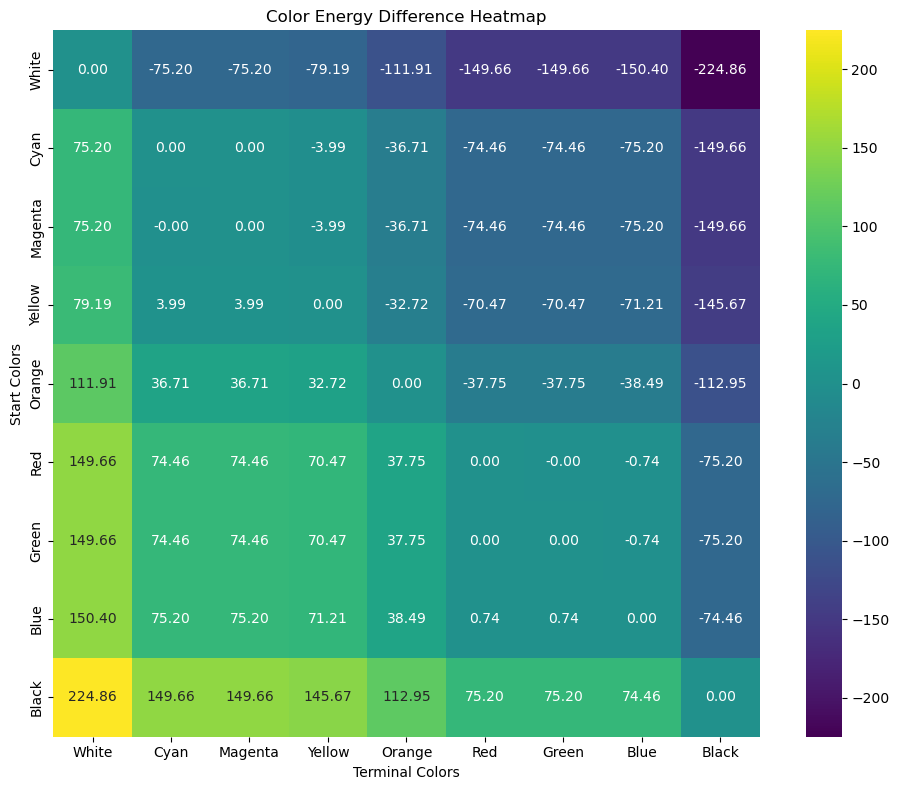

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# 创建热力图
plt.figure(figsize=(10, 8))
sns.heatmap(pd.DataFrame(rgb_energydiff), 
            xticklabels=rgb_color_names.values(), 
            yticklabels=rgb_color_names.values(),
            cmap='viridis',  # 可以使用其他颜色映射，如 'plasma', 'inferno', 'magma'
            annot=True,      # 在单元格中显示数值
            fmt='.2f',       # 数值格式
            square=True)     # 使单元格为正方形

plt.title('Color Energy Difference Heatmap')
plt.xlabel('Terminal Colors')
plt.ylabel('Start Colors')
plt.tight_layout()
plt.show()

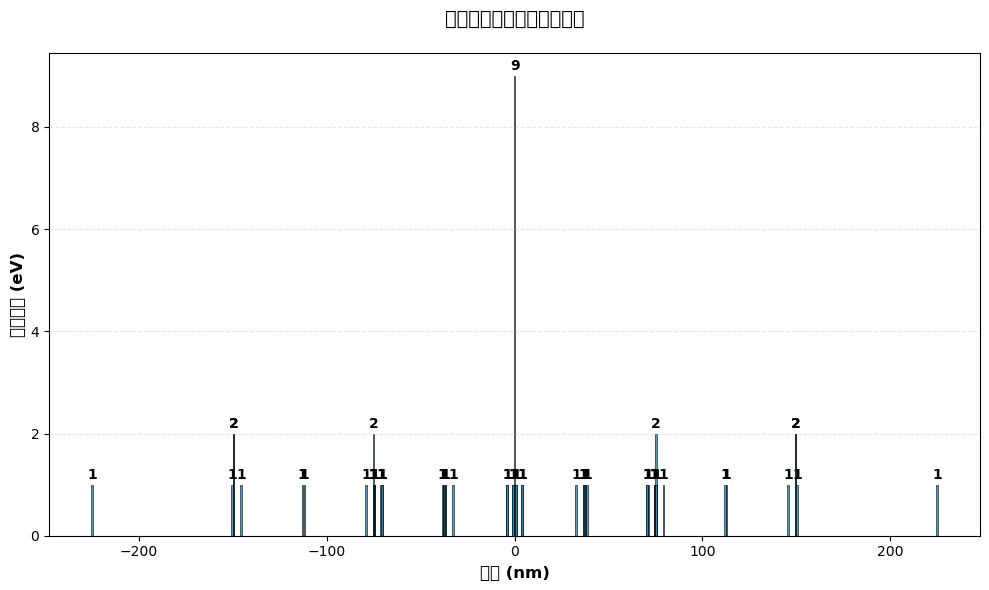

In [31]:
import matplotlib.pyplot as plt

# 设置图表风格（可选，提升美观度）
plt.style.use('default')  # 也可尝试'ggplot'、'seaborn-v0_8-whitegrid'等

# 创建画布和子图（控制尺寸）
fig, ax = plt.subplots(figsize=(10, 6))  # (宽度, 高度)，单位英寸

# 绘制垂直柱状图：x=sorted_keys（float），height=sorted_values（float）
bars = ax.bar(
    x=keys,          # x轴数据（float类型key）
    height=values,   # y轴数据（float类型value）
    width=0.8,               # 柱子宽度（根据key的间隔调整，避免过宽/过窄）
    color='#2E86AB',        # 柱子颜色（十六进制/英文名称，如'blue'）
    alpha=0.8,              # 透明度（0-1，避免遮挡）
    edgecolor='black',      # 柱子边框颜色
    linewidth=0.5           # 柱子边框宽度
)

# ---------------------- 3. 美化图表（添加标签、标题、网格等） ----------------------
# 设置x轴和y轴标签（含单位，清晰表达含义）
ax.set_xlabel('波长 (nm)', fontsize=12, fontweight='bold')  # x轴标签
ax.set_ylabel('相对能量 (eV)', fontsize=12, fontweight='bold')  # y轴标签

# 设置图表标题（简洁明了）
ax.set_title('不同波长光的相对能量分布', fontsize=14, fontweight='bold', pad=20)

# 设置x轴和y轴的数值范围（可选，避免自动范围导致图表不协调）
# ax.set_xlim(min(sorted_keys)-20, max(sorted_keys)+20)  # x轴范围：左右各留20的余量
# ax.set_ylim(0, max(sorted_values) * 1.1)  # y轴范围：从0到最大值的1.1倍，突出数据

# 添加网格线（辅助读取数值）
ax.grid(axis='y', alpha=0.3, linestyle='--')  # 仅y轴添加虚线网格，透明度0.3

# 在柱子顶部添加数值标签（显示具体value）
for bar, value in zip(bars, values):
    height = bar.get_height()  # 获取柱子高度（即value）
    ax.text(
        bar.get_x() + bar.get_width()/2,  # 标签x位置：柱子中心
        height + 0.05,                    # 标签y位置：柱子顶部+0.05（避免重叠）
        f'{value}',                  # 标签内容：保留2位小数
        ha='center', va='bottom',         # 水平/垂直居中
        fontsize=10, fontweight='bold'
    )

# 调整布局（避免标签被截断）
plt.tight_layout()

# 显示图表（运行时）或保存为图片（可注释掉plt.show()，仅保存）
plt.show()
# plt.savefig('energy_bar_chart.png', dpi=300, bbox_inches='tight')  # 保存为高清图片

In [66]:
default_colors = [
    "#f01e1e",
    "#ba6300",
    "#6f8000",
    "#008c00",
    "#009064",
    "#008fb0",
    "#befbff"
]


def plot_pupil_energydiff(data_dict,
                    alpha: float = 0.2,
                    figsize: tuple = (12, 8),
                    title: str = "PD Values with Confidence Interval",
                    xlabel: str = "Time (s)",
                    ylabel: str = "PD Value",
                    sampling_rate: float = 50.0,
                    time_interval: float = 1.0,
                    change_start: float = 0,
                    grid: bool = True,
                    legend: bool = True) -> plt.Figure:
    # 设置中文字体
    plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'SimSun', 'FangSong', 'KaiTi']
    plt.rcParams['axes.unicode_minus'] = False
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # 确定最大数据长度
    max_length = 0
    for df_list in data_dict.values():
        for df in df_list:
            max_length = max(max_length, len(df))
    
    time_axis = np.arange(max_length) / sampling_rate
    
    # 为每个组别绘制数据
    for idx, (diff_group, df_list) in enumerate(data_dict.items()):
        if not df_list:
            continue
            
        # 整合所有DataFrame的leftPD和rightPD
        all_data = []
        
        for df in df_list:
            # 确保数据长度一致，不足的用NaN填充
            if len(df) < max_length:
                padded_left = np.full(max_length, np.nan)
                padded_right = np.full(max_length, np.nan)
                padded_left[:len(df)] = df['leftPD'].values
                padded_right[:len(df)] = df['rightPD'].values
            else:
                padded_left = df['leftPD'].values[:max_length]
                padded_right = df['rightPD'].values[:max_length]
            
            all_data.append(padded_left)
            all_data.append(padded_right)
        
        # 转换为numpy数组
        data_array = np.array(all_data)
        
        # 计算均值和置信区间
        _mean = np.nanmean(data_array, axis=0)
        _std = np.nanstd(data_array, axis=0)
        
        # 95%置信区间
        n_samples = len(df_list)
        _ci = 1.96 * _std / np.sqrt(n_samples)
        
        # 绘制Left PD
        if change_start > 0:
            _s = _mean[int(change_start*sampling_rate)]
            ax.plot(time_axis, _mean-_s, color=default_colors[idx], linewidth=2, label=f'Energy Differences : {diff_group}', alpha=0.9)
            ax.fill_between(time_axis, _mean - _ci - _s, _mean + _ci - _s, color=default_colors[idx], alpha=alpha)
        else:
            ax.plot(time_axis, _mean, color=default_colors[idx], linewidth=2, label=f'Energy Differences : {diff_group}', alpha=0.9)
            ax.fill_between(time_axis, _mean - _ci, _mean + _ci, color=default_colors[idx], alpha=alpha)

    
    # 添加垂直虚线
    max_time = max_length / sampling_rate
    for t in np.arange(0, max_time + time_interval, time_interval):
        ax.axvline(x=t, color='gray', linestyle=':', alpha=0.5, linewidth=0.8)
    
    # 设置图形属性
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    
    if grid:
        ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    
    if legend:
        ax.legend(loc='lower left', fontsize=10, framealpha=0.9)
    
    # 美化图形
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_alpha(0.3)
    ax.spines['bottom'].set_alpha(0.3)
    
    plt.tight_layout()
    return fig

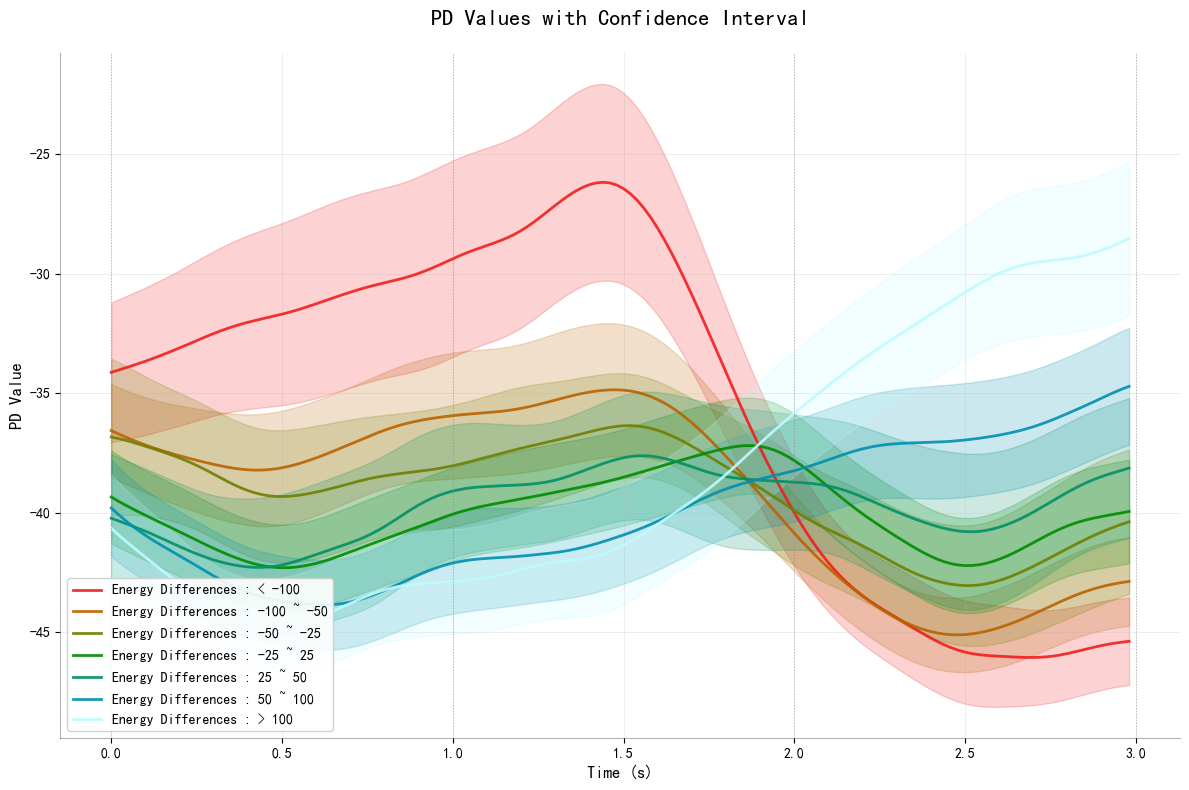

In [67]:
fig = plot_pupil_energydiff(energydiff_cluster, change_start=0)